In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import daft




WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


## Part 1 - Cognitive Load and Pupil Size 

**Increased cognitive load grows pupil size** (Mahtot, 2018). The dataset in `pupil.csv` is from the Wahn et al.'s (2016) object tracking experiments, in which the subject tracks randomly moving objects on a computer screen. Firstly, the target objects are shown to the subject. Then the objects move randomly across the screen with other objects. After some time, the objects stop, and the subject identifies the target objects. 

<div>
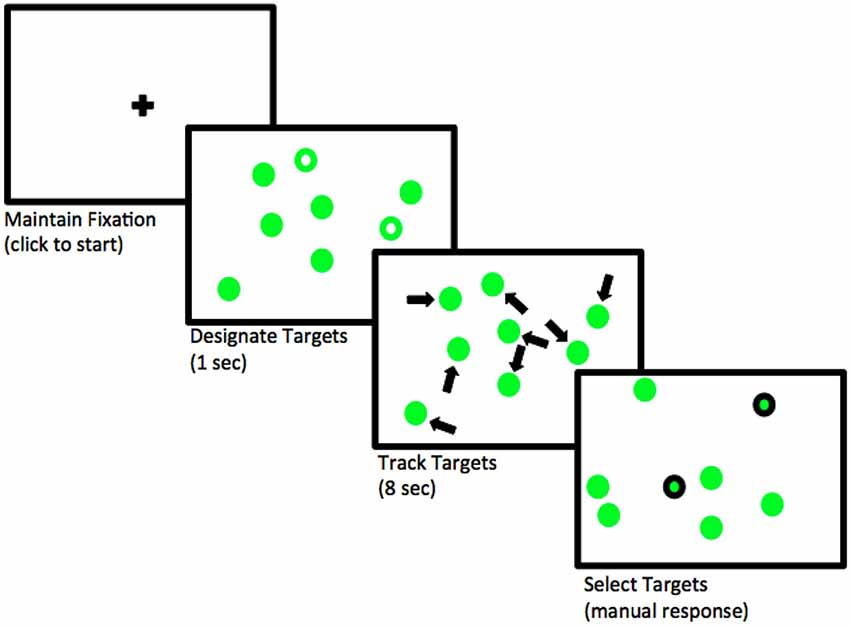
</div>

Our goal is to examine how the number of moving objects affects pupil size. 

In the `pupil.csv` dataset `load` is the number of moving objects, and `p_size` is the pupil size

In [3]:
dpupil = pd.read_csv("pupil.csv")
dpupil.head()



,trial,load,p_size
0,1,2,1021.408566
1,2,1,951.434880
2,3,5,1063.956947
3,4,4,913.487077
4,5,0,602.686850


a) Draw a DAG for the underlying causal assumptions of your analysis. DAG will include variable $L$ for `load` and $P$ for `p_size`. (5)

> *You can need to use a graph library for drawing the DAG. There are many alternatives.*

<Axes:>

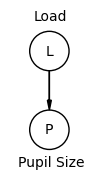

In [4]:
pgm = daft.PGM(dpi=100)
pgm.add_node("P","P",1,-1)
pgm.add_node("L","L",1,0)


pgm.add_text(0.60, -1.5, "Pupil Size")
pgm.add_text(0.80,0.35, "Load")

pgm.add_edge("L","P")

pgm.render()



b) Build a linear regression model for the relation between load and pupil  size. Show that 50 regression lines based purely on your priors in the model. (20)

$$\begin{align*} Psize_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha + \beta (L_i - \bar L) 
\\
\alpha &\sim \text{Normal}(700,100) 
\\
\color{black}{\beta \ } &\color{black}{\sim \text{Normal}(0,100)}
\\
\sigma &\sim \text{Uniform}(0,200) \end{align*} $$

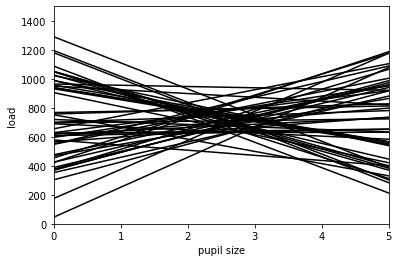

In [5]:
with pm.Model() as m_1:
    alpha = pm.Normal('alpha', mu = 700, sigma = 100)
    beta = pm.Normal('beta', mu = 0, sigma = 100)
    sigma = pm.Uniform('sigma', lower = 0, upper = 200)
    mu = alpha + beta*(dpupil.load - dpupil.load.mean())
    p_size = pm.Normal('p_size', mu = mu,  sigma = sigma, observed = dpupil.p_size)
    
N = 50
alpha = np.random.normal(700, 100, N)
beta = np.random.normal(0, 100, N)
lbar = 2.5
lseq = np.linspace(0, 5, 100)

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(lseq, alpha[i] + beta[i]*(lseq - lbar), "k")
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 1500)
    ax.set_xlabel("pupil size")
    ax.set_ylabel("load")

c) Compute the posterior parameters of the regression model. Print the summary statistics for the posterior parameters. Draw the plots of posterior parameter densities. (10)

In [6]:
with pm.Model() as m_1:
    alpha = pm.Normal('alpha', mu = 700, sigma = 100)
    beta = pm.Normal('beta', mu = 0, sigma = 100)
    sigma = pm.Uniform('sigma', lower = 0, upper = 200)
    mu = alpha + beta*(dpupil.load - dpupil.load.mean())
    p_size = pm.Normal('p_size', mu = mu,  sigma = sigma, observed = dpupil.p_size)
    trace_43 = pm.sample(1000, tune = 1000, return_inferencedata=True)
az.summary(trace_43, kind = "stats")    

    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8886722469139374, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%
alpha,701.855,19.498,664.697,738.737
beta,33.817,12.002,11.797,56.609
sigma,128.185,15.464,101.659,157.701


array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

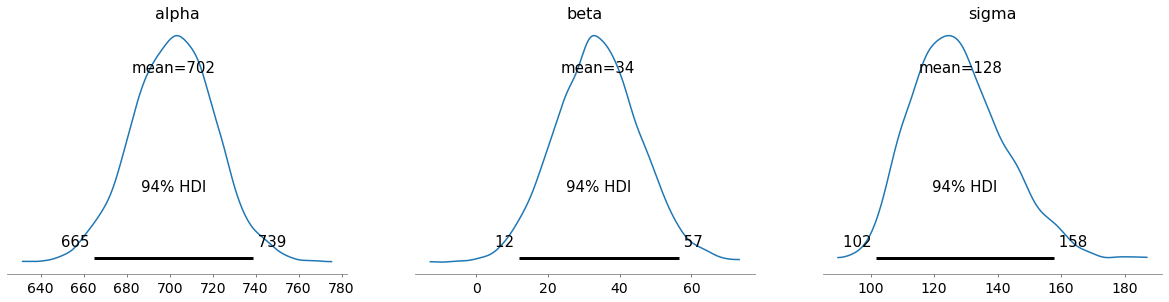

In [7]:
# Plots of posterior parameter densities
az.plot_posterior(trace_43, hdi_prob=0.94)

d) Provide predicted $P$ and 92% density intervals when there is 0, 1, 2 and 3 objects (*you need to do posterior predictive analysis, you can do interventions if you want, or you need to sample posteriors with these conditions*).  Fill in the table below: (20)

| `load` | expected `p_size` | 92% HDI |
| ------ | ----------------- | ------- |
| 0      | 618.476           | 677-554 |
| 1      | 652.421           | 701-609 |
| 2      | 686.366           | 722-651 |
| 3      | 720.312           | 757-685 |



<AxesSubplot:title={'center':'x'}>

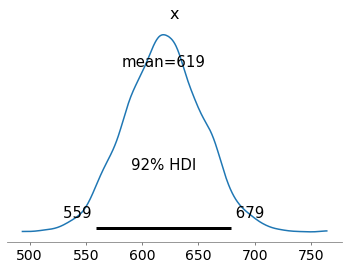

In [8]:
#Posterior Predictive Analysis
load_seq = (0,1,2,3,4)
samples = trace_43.posterior.to_dataframe()
mu_pred = np.zeros((len(load_seq), len(samples)))
for i, l in enumerate(load_seq):
    mu_pred[i] = samples['alpha'] + samples['beta'] * (l - dpupil.load.mean())

#Predicted Pupil size when load is 0    
az.plot_posterior(mu_pred[0],hdi_prob=0.92)




<AxesSubplot:title={'center':'x'}>

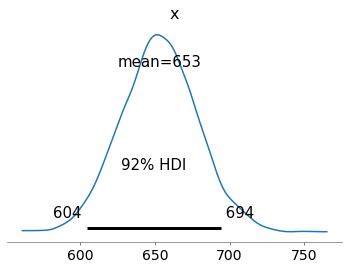

In [9]:
#Predicted Pupil size when load is 1
az.plot_posterior(mu_pred[1],hdi_prob=0.92)

<AxesSubplot:title={'center':'x'}>

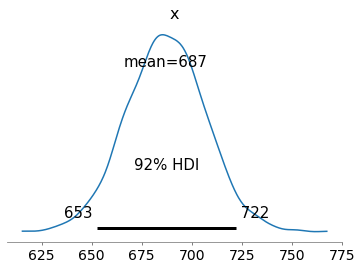

In [10]:
#Predicted Pupil size when load is 2
az.plot_posterior(mu_pred[2],hdi_prob=0.92)

<AxesSubplot:title={'center':'x'}>

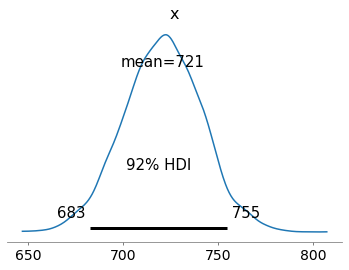

In [11]:
#Predicted Pupil size when load is 0 
az.plot_posterior(mu_pred[3],hdi_prob=0.92)

<AxesSubplot:title={'center':'x'}>

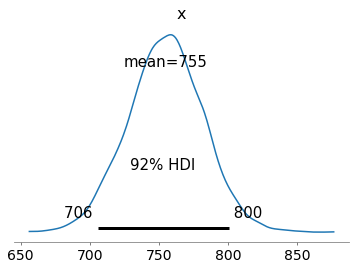

In [12]:
#Predicted Pupil size when load is 4
az.plot_posterior(mu_pred[4],hdi_prob=0.92)

e) Show the posterior predictive distribution of the difference of the pupil size `load = 4` and pupil size `load = 1`. (10)

$$p(p\_{size} | load = 4) - p(p\_{size} | load = 1)$$

Text(-14, 0.02, '0%')

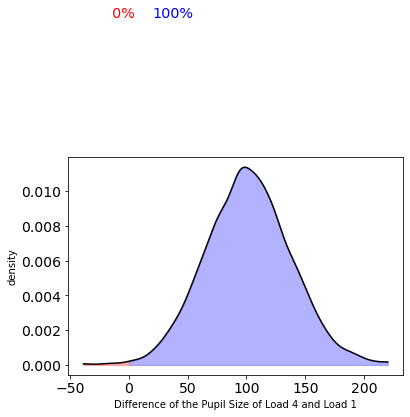

In [13]:
#Plot of the difference of pupil size when load is 4 and when load is 1. 
#I used the posterior predictive results that I found above for load 1 and load 4 

pupil_difference= mu_pred[4] - mu_pred[1]

ax = az.plot_dist(pupil_difference, color="k")
ax.set_xlabel("Difference of the Pupil Size of Load 4 and Load 1")
ax.set_ylabel("density")

l1 = ax.lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
ax.fill_between(x1[x1>0],y1[x1>0], color="blue", alpha=0.3)
ax.fill_between(x1[x1<0],y1[x1<0], color="red", alpha=0.3)
ax.text(20,0.02,"{0:.0f}%".format(np.mean((mu_pred[4] - mu_pred[1])>0) * 100), color = "blue", fontsize= "x-large")
ax.text(-14,0.02,"{0:.0f}%".format(np.mean((mu_pred[1] - mu_pred[4] )>0) * 100), color = "red", fontsize= "x-large")






## Part 2  - Powerpose and Testerone 

The `powerpose.csv` dataset (Fosse ,2016) shows the testerone measurements of 39 people, before and after they were assigned to a treatment. The treatment refers to have a high power pose or low power pose. 

- `hptreat`: Powerpose treatment, `1` is high power pose, `0` is low power pose. 
- `female`: Sex, `1` is female, `0` male
- `age`: Age, in years.
- `testm1`: testerone level before treatment, in picograms per milileter (pg/ml)
- `testm2`: testerone level after treatment, in picograms per milileter (pg/ml)


In [14]:
dpower = pd.read_csv("powerpose.csv")
dpower
ct=(dpower.testm2-dpower.testm1)
dpower["ct"]=ct
#Here ct is the change in testosterone level.I add a new variable named as ct
az.summary(dpower.to_dict(orient='list'), kind='stats')

,mean,sd,hdi_3%,hdi_97%
id,52.462,13.772,29.000,72.000
hptreat,0.513,0.506,0.000,1.000
female,0.667,0.478,0.000,1.000
age,21.282,3.713,18.000,28.000
testm1,49.842,27.667,17.995,104.815
testm2,50.006,27.469,10.430,105.485
ct,0.164,20.401,-30.060,43.550


The research question is that on average, assigning a subject a high power pose vs. a low power pose will lead to higher testosterone levels after treatment. 

Build a linear regression model to investigate this claim. Note that, you will need to define a new varaible that represents the change in testerone.

a) Draw a DAG for the underlying causal assumptions of your analysis. (5)

> *You can need to use a graph library for drawing the DAG. There are many alternatives.*

<Axes:>

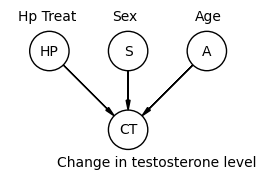

In [15]:
pgm = daft.PGM(dpi=100)
pgm.add_node("CT","CT",1,-1)
pgm.add_node("HP","HP",0,0)
pgm.add_node("S","S",1,0)
pgm.add_node("A","A",2,0)

pgm.add_text(0.10, -1.5, "Change in testosterone level")
pgm.add_text(1.85, 0.35, "Age")
pgm.add_text(-.4,0.35, "Hp Treat")
pgm.add_text(0.80,0.35, "Sex")

pgm.add_edge("HP", "CT", xoffset=-0.1)
pgm.add_edge("S","CT")
pgm.add_edge("A", "CT", xoffset=-0.1)
pgm.render()

b) Describe what your DAG describes, and justifiy your assumptions in the DAG below: 

---

In the DAG above, I assume that Power Pose Treatment (HP), Sex (S) and Age( A) cause change in testosterone level. Power pose treatment (HP), sex (S) and age (A) independent from each other. This DAG is an example of Collider. 

---

c) Build a Bayesian model based on your DAG. Compute the posterior parameters. 



$$\begin{align*} CT_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha_S +\alpha_H + \beta (A_i - \bar A) 
\\
\alpha_S &\sim \text{Normal}(0,15) 
\\
\alpha_H &\sim \text{Normal}(0,15) 
\\
\color{black}{\beta \ } &\color{black}{\sim \text{Normal}(0,30)}
\\
\sigma &\sim \text{Uniform}(0,30) \end{align*} $$

In [16]:
#Here I defined sex(s) and power pose treatment(h) as a categorical variable. 
#Alpha_s represents an alpha for sex, and alpha_h represents an alpha for power pose treatment.

with pm.Model() as testerone_model:
    alpha_s = pm.Normal('alpha_s', mu = 0, sigma = 15,shape=2)
    alpha_h = pm.Normal('alpha_h', mu = 0, sigma = 15,shape=2)
    beta = pm.Normal('beta', mu = 0, sigma = 100)
    sigma = pm.Uniform('sigma', lower = 0, upper = 30)
    mu = alpha_s[dpower.female] + alpha_h[dpower.hptreat] + beta*(dpower.age - dpower.age.mean())
    change_testerone = pm.Normal('change_testerone', mu = mu,  sigma = sigma, observed = dpower.ct)
    trace_testerone = pm.sample(1000, tune = 1000, return_inferencedata=True)
az.summary(trace_testerone, kind = "stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha_h, alpha_s]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


,mean,sd,hdi_3%,hdi_97%
alpha_s[0],1.043,9.013,-14.867,18.723
alpha_s[1],-0.819,8.567,-17.210,14.553
alpha_h[0],-3.447,8.660,-18.838,13.842
alpha_h[1],4.004,8.677,-11.500,20.961
beta,0.247,1.029,-1.746,2.168
sigma,21.354,2.568,16.663,26.266


d) Do a posterior predictive analysis with interventions. Show the causal effect of powerpose on testerone difference. Compute the testerone difference caused by the interventions $\text{do}(hptreat = 1)$ and $\text{do}(hptreat = 0)$. What is the difference between mean testerone levels and predicted testerone levels between these interventions? Show your results with figures and statistics.  


In [17]:
from theano import shared

In [18]:
hp = dpower.hptreat.values
hp_shared = shared(hp)


In [19]:
with pm.Model() as testerone_model:
    alpha_s = pm.Normal('alpha_s', mu = 0, sigma = 15,shape=2)
    alpha_h = pm.Normal('alpha_h', mu = 0, sigma = 15,shape=2)
    beta = pm.Normal('beta', mu = 0, sigma = 100)
    sigma = pm.Uniform('sigma', lower = 0, upper = 30)
    mu = alpha_s[dpower.female] + alpha_h[hp_shared] + beta*(dpower.age - dpower.age.mean())
    change_testerone = pm.Normal('change_testerone', mu = mu,  sigma = sigma, observed = dpower.ct)
    trace_testerone = pm.sample(1000, tune = 1000, return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha_h, alpha_s]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
hp_0 = np.zeros(len(hp),dtype=int)
hp_shared.set_value(hp_0)

with testerone_model:
    testorene_model_0 = pm.sample_posterior_predictive(trace_testerone )
az.summary(testorene_model_0, kind = "stats")    
   

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (4000) than draws (39). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
change_testerone,-3.616,22.545,-45.955,39.219


In [21]:
hp_1 = np.ones(len(hp),dtype=int)
hp_shared.set_value(hp_1)

with testerone_model:
    testorene_model_1 = pm.sample_posterior_predictive(trace_testerone )
az.summary(testorene_model_1, kind = "stats")      

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (4000) than draws (39). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
change_testerone,3.759,22.567,-38.666,46.422


In [22]:
# Statistics of difference in testosterone levels between interventions
az.summary(testorene_model_1["change_testerone"]-testorene_model_0["change_testerone"], kind = "stats")



/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (4000) than draws (39). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
x,7.375,31.062,-51.126,65.694


Text(-14, 0.02, '40%')

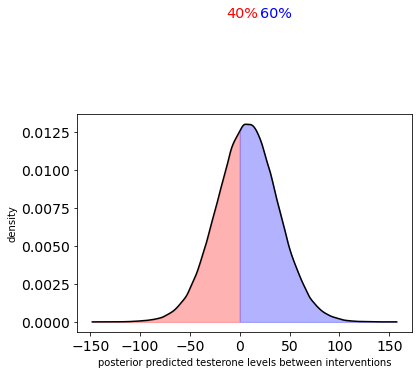

In [23]:
# Plot of the differences of testosterone level between interventions
ax = az.plot_dist(testorene_model_1["change_testerone"] - testorene_model_0["change_testerone"], color="k")
ax.set_xlabel("posterior predicted testerone levels between interventions")
ax.set_ylabel("density")

l1 = ax.lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
ax.fill_between(x1[x1>0],y1[x1>0], color="blue", alpha=0.3)
ax.fill_between(x1[x1<0],y1[x1<0], color="red", alpha=0.3)
ax.text(20,0.02,"{0:.0f}%".format(np.mean((testorene_model_1["change_testerone"] - testorene_model_0["change_testerone"])>0) * 100), color = "blue", fontsize= "x-large")
ax.text(-14,0.02,"{0:.0f}%".format(np.mean((testorene_model_0["change_testerone"] - testorene_model_1["change_testerone"])>0) * 100), color = "red", fontsize= "x-large")


## References

1. Mathot, Sebastiaan. 2018. “Pupillometry: Psychology, Physiology, and Function.” Journal of Cognition 1 (1): 16. https://doi.org/10.5334/joc.18.
1. Fosse, Nathan E. 2016. “Replication Data for ‘Power Posing: Brief Nonverbal Displays Affect Neuroendocrine Levels and Risk Tolerance’ by Carney, Cuddy, Yap (2010).” Harvard Dataverse. https://doi.org/10.7910/DVN/FMEGS6.
1. Wahn, Basil, Daniel P. Ferris, W. David Hairston, and Peter König. 2016. “Pupil Sizes Scale with Attentional Load and Task Experience in a Multiple Object Tracking Task.” PLOS ONE 11 (12): e0168087. https://doi.org/10.1371/journal.pone.0168087.